In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import NeuralNetwork
from utils import load_data
from train import Trainer

# 加载数据
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data()
print(f"训练集: {X_train.shape}, 验证集: {X_val.shape}, 测试集: {X_test.shape}")

训练集: (45000, 3072), 验证集: (5000, 3072), 测试集: (10000, 3072)


In [5]:
def plot_training_metrics(trainer):
    plt.figure(figsize=(18, 5))
    
    # 损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(trainer.train_losses, label='Train')
    plt.plot(trainer.val_losses, label='Validation')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 3, 2)
    plt.plot(trainer.train_accs, label='Train')
    plt.plot(trainer.val_accs, label='Validation')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 学习率曲线（新增）
    plt.subplot(1, 3, 3)
    plt.plot(trainer.lr_history, color='purple')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_stage1(trainer1, trainer2, trainer3, trainer4):
    plt.figure(figsize=(18, 10))
    
    # 训练集损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(trainer1.train_losses, label='32')
    plt.plot(trainer2.train_losses, label='64')
    plt.plot(trainer3.train_losses, label='128')
    plt.plot(trainer4.train_losses, label='256')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 训练集准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(trainer1.train_accs, label='32')
    plt.plot(trainer2.train_accs, label='64')
    plt.plot(trainer3.train_accs, label='128')
    plt.plot(trainer4.train_accs, label='256')
    plt.title('Training Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 验证集损失曲线
    plt.subplot(2, 2, 3)
    plt.plot(trainer1.val_losses, label='32')
    plt.plot(trainer2.val_losses, label='64')
    plt.plot(trainer3.val_losses, label='128')
    plt.plot(trainer4.val_losses, label='256')
    plt.title('Validation Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 验证集准确率曲线
    plt.subplot(2, 2, 4)
    plt.plot(trainer1.val_accs, label='32')
    plt.plot(trainer2.val_accs, label='64')
    plt.plot(trainer3.val_accs, label='128')
    plt.plot(trainer4.val_accs, label='256')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

In [6]:
def visualize_first_layer_weights(model, n_neurons=64, save_path=None):
    # 获取第一个全连接层的权重
    W1 = model.linear1.W  # 形状应为 (3072, hidden_dim1)
    
    # 设置显示参数
    rows = int(np.sqrt(n_neurons))
    cols = int(np.ceil(n_neurons / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    # # 计算全局归一化范围
    # global_min = W1.min()
    # global_max = W1.max()
    
    for i in range(n_neurons):
        ax = axes[i//cols, i%cols] if n_neurons > 1 else axes
        # 获取第i个神经元的权重并重塑形状
        weight_vector = W1[:, i]
        
        # 关键修正：直接按HWC格式逐像素重塑
        img = weight_vector.reshape(32, 32, 3)  # 直接重塑为HWC格式
        
        # # 全局归一化
        # img = (img - global_min) / (global_max - global_min)

        neuron_min = weight_vector.min()
        neuron_max = weight_vector.max()
        img = (img - neuron_min) / (neuron_max - neuron_min + 1e-8)  # 防止除零
        
        ax.imshow(img)
        ax.axis('off')
    
    # 移除多余的子图
    for j in range(n_neurons, rows*cols):
        axes.flat[j].set_visible(False) if n_neurons > 1 else None
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# =====示例用法=====
# # 初始化并加载训练好的模型
# model1 = NeuralNetwork(input_dim=3072, hidden_dim1=512, 
#                          hidden_dim2=256, output_dim=10)
# model1.load_weights('best_model_linearlr.npz')  # 替换为你的权重路径
    
# # 可视化前64个神经元的权重
# visualize_first_layer_weights(model1, n_neurons=64)

In [7]:
from scipy.optimize import minimize

def visualize_class_templates(model, image_shape=(32, 32, 3), save_path=None):
    """
    通过优化方法生成每个类别的模板图像
    """
    # 初始化可优化的图像参数（使用tanh确保数值范围合理）
    initial_img = np.random.randn(np.prod(image_shape)) * 0.01
    bounds = [(-1, 1)] * len(initial_img)  # 与数据归一化范围一致
    
    # 创建画布
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for class_idx in range(10):
        # 定义优化目标：最大化当前类别的输出
        def objective(x):
            # 前向传播计算分数
            x_tensor = x.reshape(1, -1)
            h1 = model.act1.forward(model.linear1.forward(x_tensor))
            h2 = model.act2.forward(model.linear2.forward(h1))
            scores = model.linear3.forward(h2)
            return -scores[0, class_idx]  # 负号因为使用最小化算法
            
        # 运行优化
        res = minimize(objective, initial_img, method='L-BFGS-B', 
                      bounds=bounds, options={'maxiter': 100})
        optimized_img = res.x
        
        # 后处理与显示
        ax = axes[class_idx//5, class_idx%5]
        img = optimized_img.reshape(image_shape)
        img = (img - img.min()) / (img.max() - img.min())  # 归一化到[0,1]
        ax.imshow(img)
        ax.set_title(f'Class {class_idx}')
        ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# =====示例用法=====
# model1 = NeuralNetwork(3072, 256, 128, 10)
# model1.load_weights('best_model_linearlr.npz')
    
# visualize_class_templates(model1)

## 一阶段
hidden_dim = [256, 128]

测试batch_size = 32, 64, 128, 256

观察Acc & Loss曲线/过拟合程度/收敛训练时间

In [ ]:
# 19m7.4s
# 20 epochs
batch_size = 32
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.002
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer1 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer1.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer1.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.6674 | Train Acc: 41.05% | Val Loss: 1.5538 | Val Acc: 45.06% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.4394 | Train Acc: 49.58% | Val Loss: 1.5276 | Val Acc: 45.86% | LR: 0.098004
Epoch 3/100 | Train Loss: 1.3371 | Train Acc: 53.14% | Val Loss: 1.4544 | Val Acc: 48.94% | LR: 0.096008
Epoch 4/100 | Train Loss: 1.2528 | Train Acc: 56.01% | Val Loss: 1.4399 | Val Acc: 50.16% | LR: 0.094012
Epoch 5/100 | Train Loss: 1.1710 | Train Acc: 58.86% | Val Loss: 1.4298 | Val Acc: 51.16% | LR: 0.092016
Epoch 6/100 | Train Loss: 1.1076 | Train Acc: 60.79% | Val Loss: 1.4263 | Val Acc: 51.46% | LR: 0.090020
Epoch 7/100 | Train Loss: 1.0510 | Train Acc: 63.03% | Val Loss: 1.4303 | Val Acc: 51.58% | LR: 0.088024
Epoch 8/100 | Train Loss: 0.9936 | Train Acc: 65.13% | Val Loss: 1.4738 | Val Acc: 51.52% | LR: 0.086028
Epoch 9/100 | Train Loss: 0.9342 | Train Acc: 67.28% | Val Loss: 1.4825 | Val Acc: 51.40% | LR: 0.084032
Epoch 10/100 | Train Loss: 0.8885 | Train Acc: 69.11% |

In [ ]:
# 15m47s
# 34 epochs
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.002
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer2 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer2.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer2.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.7523 | Train Acc: 38.42% | Val Loss: 1.6390 | Val Acc: 42.66% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.5495 | Train Acc: 46.10% | Val Loss: 1.5867 | Val Acc: 44.34% | LR: 0.098004
Epoch 3/100 | Train Loss: 1.4489 | Train Acc: 49.49% | Val Loss: 1.5166 | Val Acc: 46.10% | LR: 0.096008
Epoch 4/100 | Train Loss: 1.3832 | Train Acc: 51.93% | Val Loss: 1.4950 | Val Acc: 46.50% | LR: 0.094012
Epoch 5/100 | Train Loss: 1.3469 | Train Acc: 53.32% | Val Loss: 1.4666 | Val Acc: 48.54% | LR: 0.092016
Epoch 6/100 | Train Loss: 1.2979 | Train Acc: 55.24% | Val Loss: 1.4960 | Val Acc: 47.04% | LR: 0.090020
Epoch 7/100 | Train Loss: 1.2996 | Train Acc: 55.01% | Val Loss: 1.4750 | Val Acc: 48.38% | LR: 0.088024
Epoch 8/100 | Train Loss: 1.2410 | Train Acc: 57.27% | Val Loss: 1.4796 | Val Acc: 48.90% | LR: 0.086028
Epoch 9/100 | Train Loss: 1.1997 | Train Acc: 58.70% | Val Loss: 1.4367 | Val Acc: 50.04% | LR: 0.084032
Epoch 10/100 | Train Loss: 1.1768 | Train Acc: 59.67% |

In [ ]:
# 8m10.7s
# 34 epochs
batch_size = 128
learning_rate = 0.5
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.002
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer3 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer3.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer3.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.7466 | Train Acc: 38.44% | Val Loss: 1.6205 | Val Acc: 43.50% | LR: 0.500000
Epoch 2/100 | Train Loss: 1.5068 | Train Acc: 47.59% | Val Loss: 1.5344 | Val Acc: 47.00% | LR: 0.490020
Epoch 3/100 | Train Loss: 1.4019 | Train Acc: 51.51% | Val Loss: 1.4886 | Val Acc: 47.94% | LR: 0.480040
Epoch 4/100 | Train Loss: 1.3245 | Train Acc: 53.96% | Val Loss: 1.4612 | Val Acc: 48.56% | LR: 0.470060
Epoch 5/100 | Train Loss: 1.2596 | Train Acc: 56.50% | Val Loss: 1.4394 | Val Acc: 49.30% | LR: 0.460080
Epoch 6/100 | Train Loss: 1.2057 | Train Acc: 58.28% | Val Loss: 1.4260 | Val Acc: 50.52% | LR: 0.450100
Epoch 7/100 | Train Loss: 1.1530 | Train Acc: 60.21% | Val Loss: 1.4162 | Val Acc: 51.00% | LR: 0.440120
Epoch 8/100 | Train Loss: 1.1044 | Train Acc: 61.85% | Val Loss: 1.4111 | Val Acc: 51.50% | LR: 0.430140
Epoch 9/100 | Train Loss: 1.0641 | Train Acc: 63.36% | Val Loss: 1.4156 | Val Acc: 50.64% | LR: 0.420160
Epoch 10/100 | Train Loss: 1.0187 | Train Acc: 65.04% |

In [ ]:
# 7m25.5s
# 43 epochs
batch_size = 256
learning_rate = 0.5
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.002
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer4 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer4.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer4.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.9246 | Train Acc: 31.54% | Val Loss: 1.7592 | Val Acc: 38.16% | LR: 0.500000
Epoch 2/100 | Train Loss: 1.6751 | Train Acc: 41.45% | Val Loss: 1.6682 | Val Acc: 41.62% | LR: 0.490020
Epoch 3/100 | Train Loss: 1.5891 | Train Acc: 44.50% | Val Loss: 1.6144 | Val Acc: 43.44% | LR: 0.480040
Epoch 4/100 | Train Loss: 1.5316 | Train Acc: 46.80% | Val Loss: 1.5811 | Val Acc: 44.88% | LR: 0.470060
Epoch 5/100 | Train Loss: 1.4857 | Train Acc: 48.60% | Val Loss: 1.5553 | Val Acc: 45.82% | LR: 0.460080
Epoch 6/100 | Train Loss: 1.4478 | Train Acc: 50.13% | Val Loss: 1.5366 | Val Acc: 46.04% | LR: 0.450100
Epoch 7/100 | Train Loss: 1.4148 | Train Acc: 51.22% | Val Loss: 1.5206 | Val Acc: 47.08% | LR: 0.440120
Epoch 8/100 | Train Loss: 1.3853 | Train Acc: 52.26% | Val Loss: 1.5031 | Val Acc: 47.54% | LR: 0.430140
Epoch 9/100 | Train Loss: 1.3576 | Train Acc: 53.25% | Val Loss: 1.4937 | Val Acc: 47.98% | LR: 0.420160
Epoch 10/100 | Train Loss: 1.3325 | Train Acc: 54.31% |

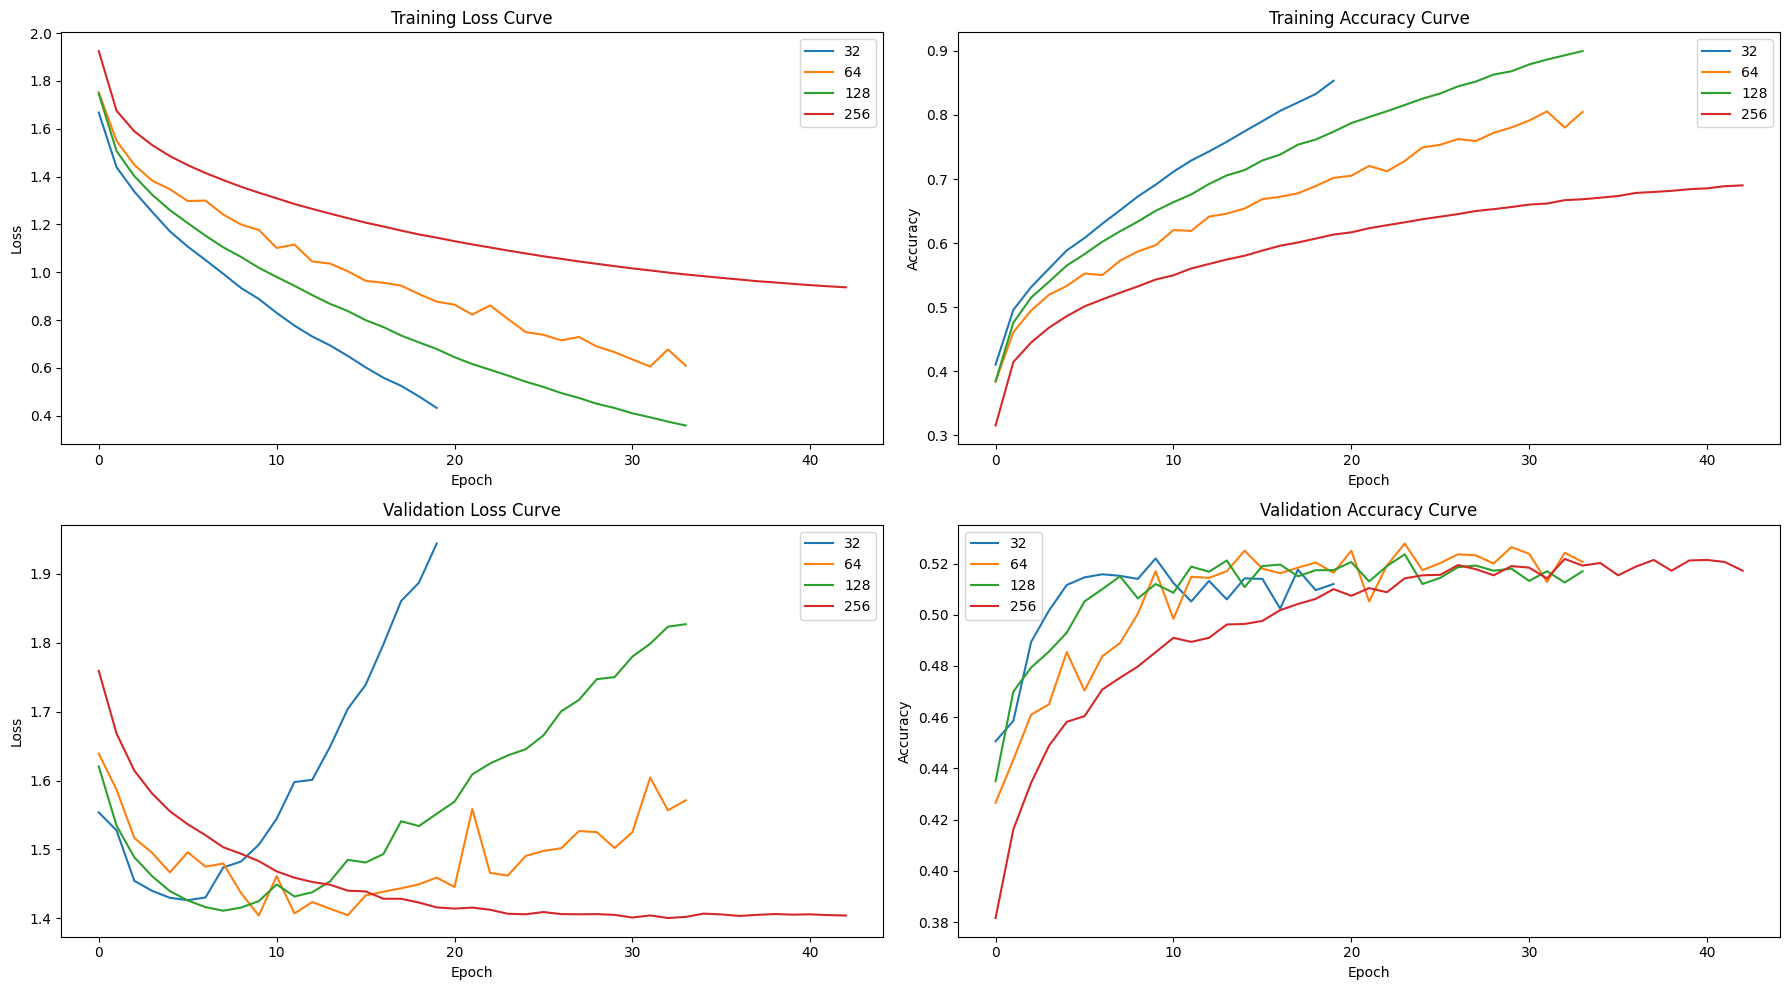

In [24]:
plot_training_stage1(trainer1, trainer2, trainer3, trainer4)

## 一阶段conclusion：Batch_size = 64

## 二阶段：探索Hidden_dim
[128, 64]  reg = 0.00015

[256, 128]  reg = 0.00015

[512, 256]  reg = 0.00015

[1024, 512]  reg = 0.00015

with batch_size = 64, lr = 0.1

### ===================small=====================

In [3]:
# 8m24.2s
# 57 epochs
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 128     # 第一隐藏层神经元数
hidden_dim2 = 64      # 第二隐藏层神经元数
reg = 0.00015            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.001
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer5 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer5.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer5.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.8176 | Train Acc: 37.04% | Val Loss: 1.7005 | Val Acc: 40.86% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.6247 | Train Acc: 44.10% | Val Loss: 1.6286 | Val Acc: 42.86% | LR: 0.098002
Epoch 3/100 | Train Loss: 1.5476 | Train Acc: 46.95% | Val Loss: 1.5785 | Val Acc: 44.42% | LR: 0.096004
Epoch 4/100 | Train Loss: 1.5130 | Train Acc: 47.88% | Val Loss: 1.5447 | Val Acc: 45.50% | LR: 0.094006
Epoch 5/100 | Train Loss: 1.4642 | Train Acc: 49.64% | Val Loss: 1.5307 | Val Acc: 46.32% | LR: 0.092008
Epoch 6/100 | Train Loss: 1.4379 | Train Acc: 50.74% | Val Loss: 1.5361 | Val Acc: 46.04% | LR: 0.090010
Epoch 7/100 | Train Loss: 1.4271 | Train Acc: 50.89% | Val Loss: 1.4754 | Val Acc: 48.08% | LR: 0.088012
Epoch 8/100 | Train Loss: 1.3921 | Train Acc: 51.90% | Val Loss: 1.4790 | Val Acc: 47.72% | LR: 0.086014
Epoch 9/100 | Train Loss: 1.3801 | Train Acc: 52.56% | Val Loss: 1.4544 | Val Acc: 49.28% | LR: 0.084016
Epoch 10/100 | Train Loss: 1.3497 | Train Acc: 53.56% |

### ===============medidum======================

In [ ]:
# 12m5.8s
# 48 epochs
# 55.32
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.00015            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.0001
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer6 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer6.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer6.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.8121 | Train Acc: 38.02% | Val Loss: 1.7062 | Val Acc: 40.64% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.6304 | Train Acc: 44.70% | Val Loss: 1.6091 | Val Acc: 45.06% | LR: 0.098000
Epoch 3/100 | Train Loss: 1.5335 | Train Acc: 48.03% | Val Loss: 1.5627 | Val Acc: 45.96% | LR: 0.096000
Epoch 4/100 | Train Loss: 1.4747 | Train Acc: 49.87% | Val Loss: 1.5454 | Val Acc: 46.38% | LR: 0.094001
Epoch 5/100 | Train Loss: 1.4358 | Train Acc: 50.96% | Val Loss: 1.5149 | Val Acc: 46.98% | LR: 0.092001
Epoch 6/100 | Train Loss: 1.4141 | Train Acc: 51.79% | Val Loss: 1.5006 | Val Acc: 47.36% | LR: 0.090001
Epoch 7/100 | Train Loss: 1.3745 | Train Acc: 53.05% | Val Loss: 1.4632 | Val Acc: 49.12% | LR: 0.088001
Epoch 8/100 | Train Loss: 1.3492 | Train Acc: 53.84% | Val Loss: 1.4739 | Val Acc: 48.16% | LR: 0.086001
Epoch 9/100 | Train Loss: 1.3359 | Train Acc: 54.24% | Val Loss: 1.4306 | Val Acc: 50.42% | LR: 0.084002
Epoch 10/100 | Train Loss: 1.3146 | Train Acc: 55.03% |

### ===========large============ 

In [ ]:
# 45m57.3s
# 54 epochs
# reg
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 512     # 第一隐藏层神经元数
hidden_dim2 = 256      # 第二隐藏层神经元数
reg = 0.00015            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.0001
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer8 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer8.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer8.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.8425 | Train Acc: 38.81% | Val Loss: 1.7172 | Val Acc: 43.04% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.6254 | Train Acc: 46.58% | Val Loss: 1.6284 | Val Acc: 44.66% | LR: 0.098000
Epoch 3/100 | Train Loss: 1.5322 | Train Acc: 49.14% | Val Loss: 1.5936 | Val Acc: 45.84% | LR: 0.096000
Epoch 4/100 | Train Loss: 1.4858 | Train Acc: 50.78% | Val Loss: 1.5552 | Val Acc: 46.88% | LR: 0.094001
Epoch 5/100 | Train Loss: 1.4331 | Train Acc: 52.28% | Val Loss: 1.4924 | Val Acc: 49.46% | LR: 0.092001
Epoch 6/100 | Train Loss: 1.3897 | Train Acc: 53.41% | Val Loss: 1.4712 | Val Acc: 49.52% | LR: 0.090001
Epoch 7/100 | Train Loss: 1.3604 | Train Acc: 54.36% | Val Loss: 1.5288 | Val Acc: 48.44% | LR: 0.088001
Epoch 8/100 | Train Loss: 1.3688 | Train Acc: 54.34% | Val Loss: 1.4662 | Val Acc: 49.70% | LR: 0.086001
Epoch 9/100 | Train Loss: 1.3427 | Train Acc: 54.94% | Val Loss: 1.4339 | Val Acc: 50.20% | LR: 0.084002
Epoch 10/100 | Train Loss: 1.2990 | Train Acc: 55.93% |

### ===============huge=================

In [ ]:
# 868m29.3s 
# 54 epochs
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 1024     # 第一隐藏层神经元数
hidden_dim2 = 512      # 第二隐藏层神经元数
reg = 0.00015            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.0001
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer9 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer9.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer9.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.9243 | Train Acc: 39.81% | Val Loss: 1.8182 | Val Acc: 42.28% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.6966 | Train Acc: 47.11% | Val Loss: 1.7042 | Val Acc: 45.36% | LR: 0.098000
Epoch 3/100 | Train Loss: 1.5875 | Train Acc: 50.04% | Val Loss: 1.6211 | Val Acc: 47.44% | LR: 0.096000
Epoch 4/100 | Train Loss: 1.5212 | Train Acc: 51.55% | Val Loss: 1.5685 | Val Acc: 48.14% | LR: 0.094001
Epoch 5/100 | Train Loss: 1.4562 | Train Acc: 53.33% | Val Loss: 1.5717 | Val Acc: 47.32% | LR: 0.092001
Epoch 6/100 | Train Loss: 1.4372 | Train Acc: 53.88% | Val Loss: 1.5088 | Val Acc: 49.66% | LR: 0.090001
Epoch 7/100 | Train Loss: 1.3702 | Train Acc: 55.50% | Val Loss: 1.5041 | Val Acc: 48.98% | LR: 0.088001
Epoch 8/100 | Train Loss: 1.3554 | Train Acc: 55.74% | Val Loss: 1.4672 | Val Acc: 50.54% | LR: 0.086001
Epoch 9/100 | Train Loss: 1.3365 | Train Acc: 55.73% | Val Loss: 1.4507 | Val Acc: 50.40% | LR: 0.084002
Epoch 10/100 | Train Loss: 1.3043 | Train Acc: 56.81% |

### =======================stage 2 figure========================

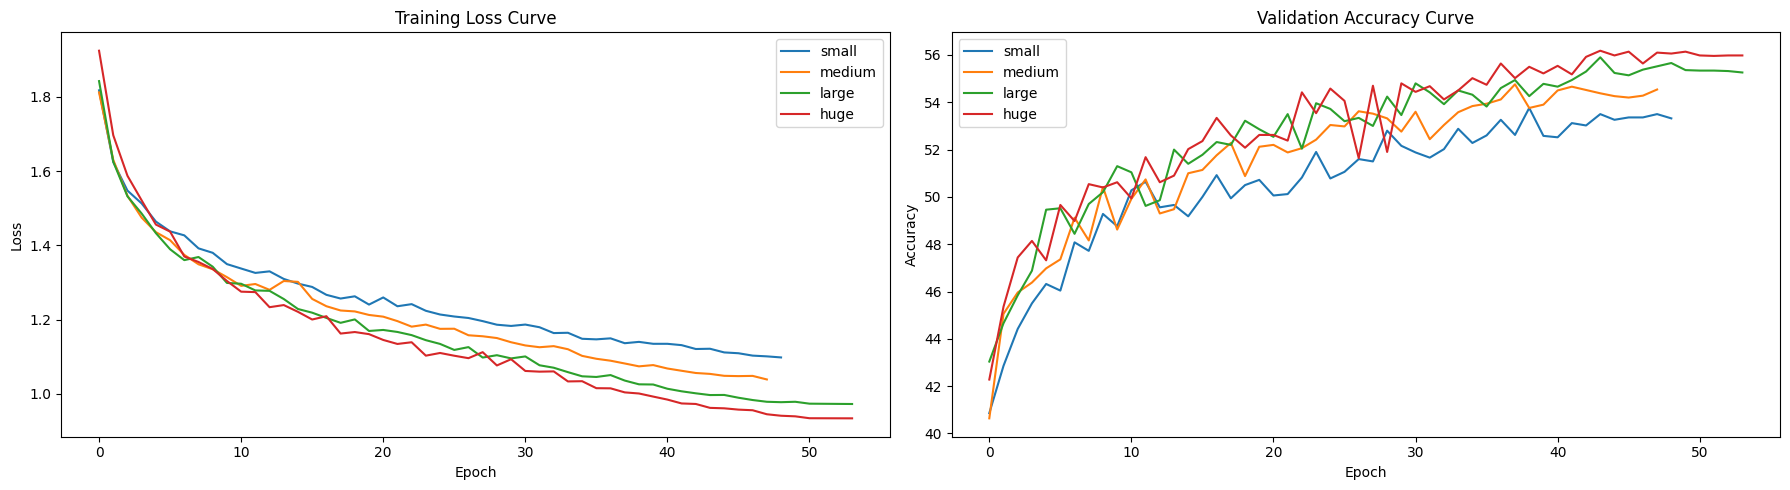

In [5]:
def plot_training_stage2():
    plt.figure(figsize=(18, 5))
    
    # 训练集损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_small, label='small')
    plt.plot(train_loss_medium, label='medium')
    plt.plot(train_loss_large, label='large')
    plt.plot(train_loss_huge, label='huge')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    


    # 验证集准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(val_acc_small, label='small')
    plt.plot(val_acc_medium, label='medium')
    plt.plot(val_acc_large, label='large')
    plt.plot(val_acc_huge, label='huge')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

plot_training_stage2()

## Stage 3

微调:

- lr_decay的两个参数`gamma` and `decay_epochs`
- 正则化强度`reg`

#### ===================MEDIUM==========================[256,128]

In [ ]:
# 106 epochs
# best_model save to "best_model_medium1"
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.00015            # L2正则化强度
epochs = 150           # 训练轮数
step_size = 100
gamma = 0.0001
patience = 15


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer6 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer6.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer6.best_val_acc*100:.2f}%")

Epoch 1/150 | Train Loss: 1.8131 | Train Acc: 38.12% | Val Loss: 1.6820 | Val Acc: 42.30% | LR: 0.100000
Epoch 2/150 | Train Loss: 1.6060 | Train Acc: 45.52% | Val Loss: 1.6357 | Val Acc: 43.34% | LR: 0.099000
Epoch 3/150 | Train Loss: 1.5513 | Train Acc: 47.31% | Val Loss: 1.5687 | Val Acc: 45.98% | LR: 0.098000
Epoch 4/150 | Train Loss: 1.4665 | Train Acc: 50.14% | Val Loss: 1.5503 | Val Acc: 46.20% | LR: 0.097000
Epoch 5/150 | Train Loss: 1.4367 | Train Acc: 51.10% | Val Loss: 1.4929 | Val Acc: 48.00% | LR: 0.096000
Epoch 6/150 | Train Loss: 1.3947 | Train Acc: 52.37% | Val Loss: 1.4790 | Val Acc: 48.36% | LR: 0.095001
Epoch 7/150 | Train Loss: 1.3661 | Train Acc: 53.50% | Val Loss: 1.5401 | Val Acc: 46.34% | LR: 0.094001
Epoch 8/150 | Train Loss: 1.3822 | Train Acc: 52.98% | Val Loss: 1.4586 | Val Acc: 48.60% | LR: 0.093001
Epoch 9/150 | Train Loss: 1.3481 | Train Acc: 53.82% | Val Loss: 1.4526 | Val Acc: 49.32% | LR: 0.092001
Epoch 10/150 | Train Loss: 1.3224 | Train Acc: 54.74% |

In [ ]:
# 29m9.1s
# 100 epochs
# 更大的reg = 0.0002
# best_model save to "best_model_medium2"
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0002            # L2正则化强度
epochs = 150           # 训练轮数
step_size = 100
gamma = 0.0001
patience = 15


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer6 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer6.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer6.best_val_acc*100:.2f}%")

Epoch 1/150 | Train Loss: 1.8318 | Train Acc: 37.80% | Val Loss: 1.7150 | Val Acc: 41.58% | LR: 0.100000
Epoch 2/150 | Train Loss: 1.6247 | Train Acc: 45.42% | Val Loss: 1.6227 | Val Acc: 44.42% | LR: 0.099000
Epoch 3/150 | Train Loss: 1.5515 | Train Acc: 47.63% | Val Loss: 1.5913 | Val Acc: 44.86% | LR: 0.098000
Epoch 4/150 | Train Loss: 1.5163 | Train Acc: 48.73% | Val Loss: 1.5428 | Val Acc: 47.18% | LR: 0.097000
Epoch 5/150 | Train Loss: 1.4632 | Train Acc: 50.18% | Val Loss: 1.5324 | Val Acc: 46.16% | LR: 0.096000
Epoch 6/150 | Train Loss: 1.4338 | Train Acc: 51.09% | Val Loss: 1.4997 | Val Acc: 47.40% | LR: 0.095001
Epoch 7/150 | Train Loss: 1.4078 | Train Acc: 51.90% | Val Loss: 1.4848 | Val Acc: 48.66% | LR: 0.094001
Epoch 8/150 | Train Loss: 1.3989 | Train Acc: 52.17% | Val Loss: 1.4650 | Val Acc: 48.42% | LR: 0.093001
Epoch 9/150 | Train Loss: 1.3784 | Train Acc: 52.72% | Val Loss: 1.4647 | Val Acc: 49.52% | LR: 0.092001
Epoch 10/150 | Train Loss: 1.3588 | Train Acc: 53.28% |

In [ ]:
# 更小的reg = 0.0001
# best_model save to "best_model_medium3"
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 256     # 第一隐藏层神经元数
hidden_dim2 = 128      # 第二隐藏层神经元数
reg = 0.0001            # L2正则化强度
epochs = 150           # 训练轮数
step_size = 100
gamma = 0.0001
patience = 15


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer6 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer6.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer6.best_val_acc*100:.2f}%")

Epoch 1/150 | Train Loss: 1.7939 | Train Acc: 37.98% | Val Loss: 1.6568 | Val Acc: 42.94% | LR: 0.100000
Epoch 2/150 | Train Loss: 1.5864 | Train Acc: 46.03% | Val Loss: 1.5785 | Val Acc: 46.04% | LR: 0.099000
Epoch 3/150 | Train Loss: 1.4985 | Train Acc: 49.06% | Val Loss: 1.5587 | Val Acc: 46.20% | LR: 0.098000
Epoch 4/150 | Train Loss: 1.4539 | Train Acc: 50.56% | Val Loss: 1.5167 | Val Acc: 47.68% | LR: 0.097000
Epoch 5/150 | Train Loss: 1.4115 | Train Acc: 51.83% | Val Loss: 1.4894 | Val Acc: 48.26% | LR: 0.096000
Epoch 6/150 | Train Loss: 1.3587 | Train Acc: 53.72% | Val Loss: 1.4576 | Val Acc: 49.16% | LR: 0.095001
Epoch 7/150 | Train Loss: 1.3272 | Train Acc: 54.62% | Val Loss: 1.4510 | Val Acc: 49.30% | LR: 0.094001
Epoch 8/150 | Train Loss: 1.3043 | Train Acc: 55.57% | Val Loss: 1.4291 | Val Acc: 50.34% | LR: 0.093001
Epoch 9/150 | Train Loss: 1.2737 | Train Acc: 56.64% | Val Loss: 1.4299 | Val Acc: 49.86% | LR: 0.092001
Epoch 10/150 | Train Loss: 1.2543 | Train Acc: 56.99% |

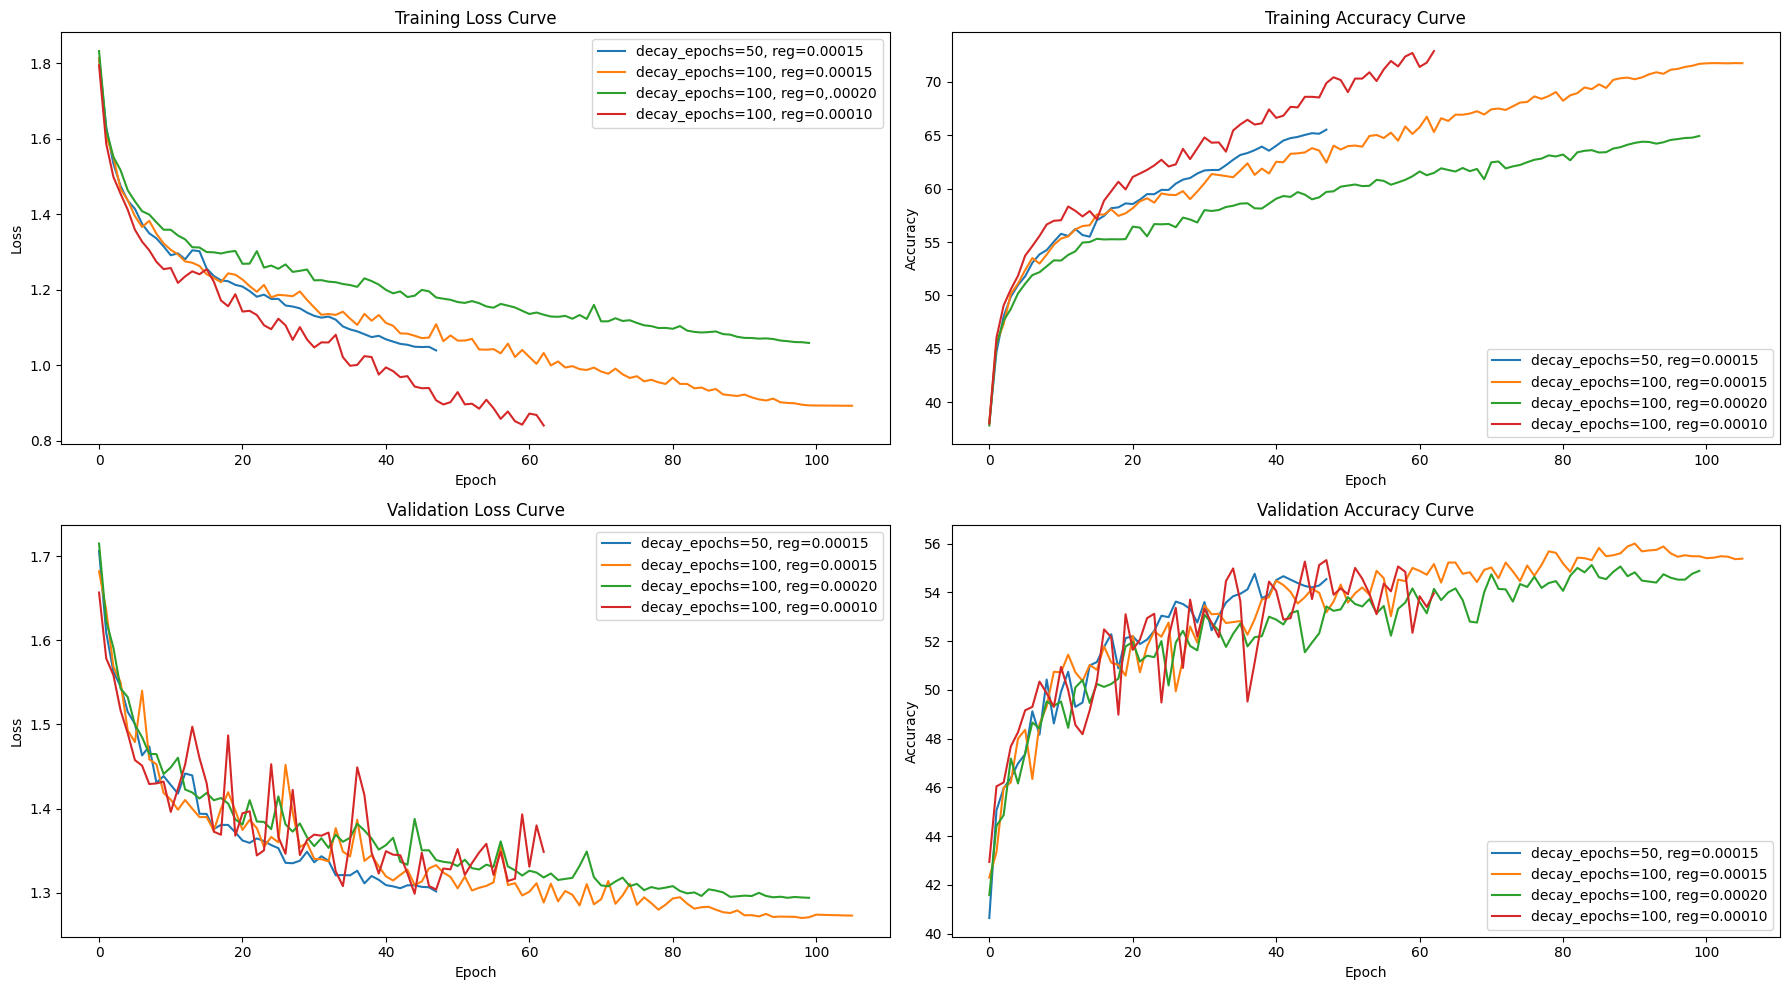

In [14]:
plt.figure(figsize=(18, 10))
    
# 训练集损失曲线
plt.subplot(2, 2, 1)
plt.plot(train_loss_1, label='decay_epochs=50, reg=0.00015')
plt.plot(train_loss_2, label='decay_epochs=100, reg=0.00015')
plt.plot(train_loss_3, label='decay_epochs=100, reg=0,.00020')
plt.plot(trainer6.train_losses, label='decay_epochs=100, reg=0.00010')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
    # 训练集准确率曲线
plt.subplot(2, 2, 2)
plt.plot(train_acc_1, label='decay_epochs=50, reg=0.00015')
plt.plot(train_acc_2, label='decay_epochs=100, reg=0.00015')
plt.plot(train_acc_3, label='decay_epochs=100, reg=0.00020')
plt.plot(train_acc_4, label='decay_epochs=100, reg=0.00010')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

    # 验证集损失曲线
plt.subplot(2, 2, 3)
plt.plot(val_loss_1, label='decay_epochs=50, reg=0.00015')
plt.plot(val_loss_2, label='decay_epochs=100, reg=0.00015')
plt.plot(val_loss_3, label='decay_epochs=100, reg=0.00020')
plt.plot(val_loss_4, label='decay_epochs=100, reg=0.00010')
plt.title('Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

    # 验证集准确率曲线
plt.subplot(2, 2, 4)
plt.plot(val_acc_1, label='decay_epochs=50, reg=0.00015')
plt.plot(val_acc_2, label='decay_epochs=100, reg=0.00015')
plt.plot(val_acc_3, label='decay_epochs=100, reg=0.00020')
plt.plot(val_acc_4, label='decay_epochs=100, reg=0.00010')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


    
plt.tight_layout()
plt.show()

### ==========LARGE WITH augment==============

In [4]:
# 
#  epochs
# reg
batch_size = 64
learning_rate = 0.1
hidden_dim1 = 512     # 第一隐藏层神经元数
hidden_dim2 = 256      # 第二隐藏层神经元数
reg = 0.00001            # L2正则化强度
epochs = 100           # 训练轮数
step_size = 50
gamma = 0.0001
patience = 10


model = NeuralNetwork(
    input_dim=3072,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    output_dim=10,
    activation='relu'
)

trainer12 = Trainer(
    model=model,
    lr=learning_rate,
    reg=reg,
    step_size=step_size,
    gamma=gamma,
    patience=patience,       
    momentum=0.9
)

trainer12.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

# ===== 打印最终性能 =====
print("\n=== 训练完成 ===")
print(f"最佳验证准确率: {trainer12.best_val_acc*100:.2f}%")

Epoch 1/100 | Train Loss: 1.8545 | Train Acc: 33.93% | Val Loss: 1.7005 | Val Acc: 39.90% | LR: 0.100000
Epoch 2/100 | Train Loss: 1.7176 | Train Acc: 39.30% | Val Loss: 1.6273 | Val Acc: 42.74% | LR: 0.098000
Epoch 3/100 | Train Loss: 1.6633 | Train Acc: 41.62% | Val Loss: 1.5691 | Val Acc: 44.48% | LR: 0.096000
Epoch 4/100 | Train Loss: 1.5990 | Train Acc: 43.73% | Val Loss: 1.5318 | Val Acc: 45.72% | LR: 0.094001
Epoch 5/100 | Train Loss: 1.5834 | Train Acc: 44.09% | Val Loss: 1.5437 | Val Acc: 45.96% | LR: 0.092001
Epoch 6/100 | Train Loss: 1.5457 | Train Acc: 45.63% | Val Loss: 1.4954 | Val Acc: 47.26% | LR: 0.090001
Epoch 7/100 | Train Loss: 1.5276 | Train Acc: 46.18% | Val Loss: 1.4688 | Val Acc: 48.78% | LR: 0.088001
Epoch 8/100 | Train Loss: 1.5152 | Train Acc: 46.95% | Val Loss: 1.4762 | Val Acc: 47.64% | LR: 0.086001
Epoch 9/100 | Train Loss: 1.5102 | Train Acc: 47.04% | Val Loss: 1.4390 | Val Acc: 49.62% | LR: 0.084002
Epoch 10/100 | Train Loss: 1.4721 | Train Acc: 48.08% |

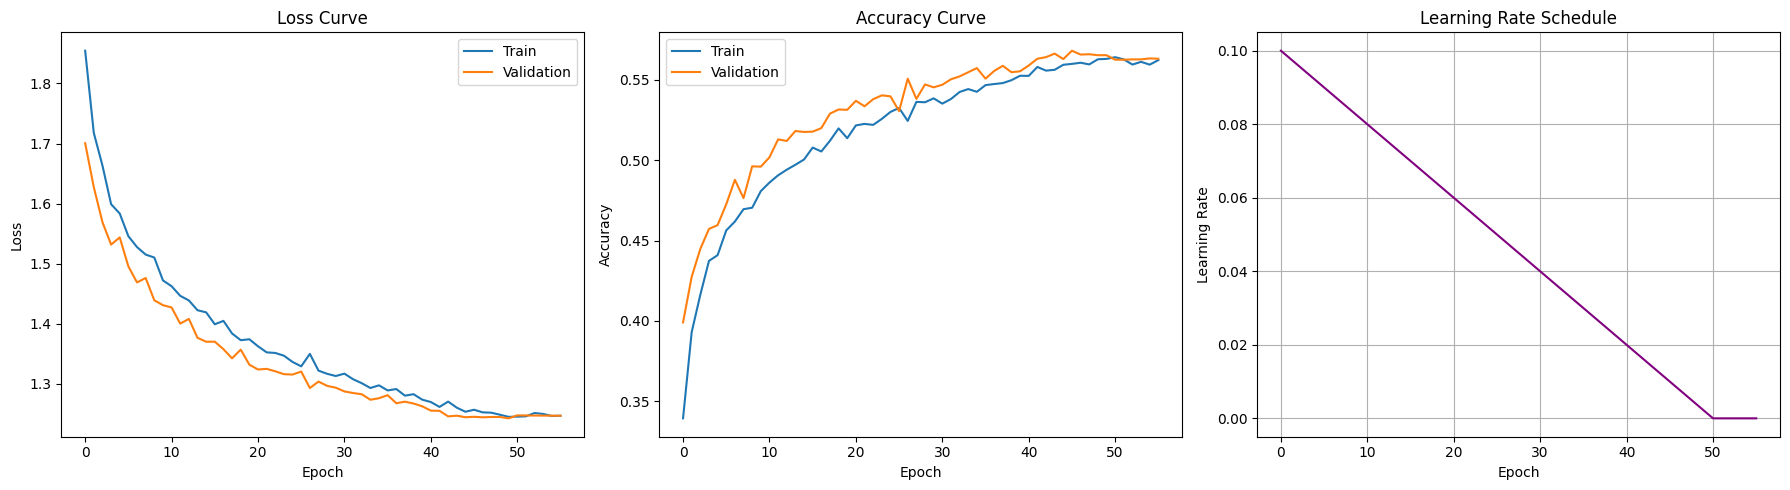

In [5]:
plot_training_metrics(trainer12)